In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from joblib import dump,load
import os
import random
import datetime as dt

def download_data(tickers,start,end):
    data=yf.download(tickers,start=start,end=end)
    data=data.stack().reset_index()
    data.drop(columns=["Close","Open","High","Low","Volume"],inplace=True)
    data.rename(columns={"level_1":"ticker","Date":"date","Adj Close":"close"},inplace=True)
    return data

def preprocess_data(df):
    df["return"]=df.groupby("ticker")["close"].pct_change()
    df["date"]=pd.to_datetime(df["date"])
    new_df = df.pivot(index = "date", columns = "ticker", values = "return")
    return new_df[1:]

#applies optimization from Frontiers paper https://www.frontiersin.org/articles/10.3389/fams.2020.577050/full
def correlated_kelly(df, cov_window=252):
    
    date_count = len(df.index)
    stock_dim = len(df.columns.unique())
    new_cols = [f"{tick}_kelly_fraction" for tick in df.columns]
    kelly_fraction_df = pd.DataFrame(index = df.index, columns = new_cols, dtype = "float64")
    kelly_fraction_df.loc[:,:] = 0.0
    
    constraints = [{'type': 'ineq', 'fun': lambda F: 1-np.sum(F)}]
    bounds = [(0,1) for _ in range(stock_dim)]
    F_initial = np.array([random.uniform(0,1/stock_dim) for _ in range(stock_dim)])
    rf_rate = .01/252
    
    for d in range(1, date_count - cov_window):
        
        start_idx = d
        end_idx = d + cov_window
        temp = df.iloc[start_idx:end_idx]      
        cov = temp.cov().values
        mean = temp.mean().values
        rfr_array = np.array([rf_rate]*stock_dim)
    
        def objective(F):
            return -(rf_rate + F.T@(mean-rfr_array)-((1/2)*F.T@cov@F))

        result = minimize(objective,F_initial,method="SLSQP",
                        bounds=bounds, constraints=constraints)
    
        if result["success"] == True:
            F=result["x"]
        else:
            print(f"Optimization could not be solved between indices {left_index},{right_index}")
            break
    
        
        kelly_fraction_df.iloc[end_idx,:] = F.T

        if end_idx%(252)==0:
            print("calculated up to: ",df.iloc[end_idx].name.date())

    new_df = pd.concat([df, kelly_fraction_df], axis = 1)

    return new_df
    

def correlated_kelly_monthly(df, cov_window=24):

    monthly_index_head = df.index.to_period("M").to_timestamp().normalize().unique()
    monthly_index_tail = df.index.to_period("M").to_timestamp(how = "end").normalize().unique()
    date_count = len(monthly_index_tail)
    stock_dim = len(df.columns.unique())
    new_cols = [f"{tick}_kelly_fraction" for tick in df.columns]
    kelly_fraction_df = pd.DataFrame(index = monthly_index_tail, columns = new_cols, dtype = "float64")
    kelly_fraction_df.loc[:,:] = 0.0
    
    constraints = [{'type': 'ineq', 'fun': lambda F: 1-np.sum(F)}]
    bounds = [(0,1) for _ in range(stock_dim)]
    F_initial = np.array([random.uniform(0,1/stock_dim) for _ in range(stock_dim)])
    rf_rate = .01/252
    
    for d in range(0, date_count - cov_window):
        
        start_idx = d
        end_idx = d + cov_window - 1
        temp = df[df.index.to_series().between(monthly_index_head[start_idx],monthly_index_tail[end_idx])]
        cov = temp.cov().values
        mean = temp.mean().values
        rfr_array = np.array([rf_rate]*stock_dim)
    
        def objective(F):
            return -(rf_rate + F.T@(mean-rfr_array)-((1/2)*F.T@cov@F))

        result = minimize(objective,F_initial,method="SLSQP",
                        bounds=bounds, constraints=constraints)
    
        if result["success"] == True:
            F=result["x"]
        else:
            print(f"Optimization could not be solved between indices {left_index},{right_index}")
            break
    
        kelly_fraction_df.loc[monthly_index_tail[end_idx+1],:] = F.T

        if d%12==0:
            print("calculated up to: ", monthly_index_tail[end_idx+1].date())

    agg_df = df.groupby(pd.Grouper(freq="M")).apply(agg_return)
    new_df = pd.concat([agg_df, kelly_fraction_df], axis = 1)

    return new_df

def forecasted_correlated_kelly(df, start_year, lag, cov_window=252):


    date_count = len(df.index)
    stock_dim = len(df.columns.unique())
    new_cols = [f"{tick}_kelly_fraction" for tick in df.columns]
    kelly_fraction_df = pd.DataFrame(index = df.index, columns = new_cols, dtype = "float64")
    kelly_fraction_df.loc[:,:] = 0.0
    
    constraints = [{'type': 'ineq', 'fun': lambda F: 1-np.sum(F)}]
    bounds = [(0,1) for _ in range(stock_dim)]
    F_initial = np.array([random.uniform(0,1/stock_dim) for _ in range(stock_dim)])
    rf_rate = .01/252

    lagged_cov_matrices = []
    predicted_cholesky = []
    sse_cholesky_list = []
    dates = []
    
    for d in range(1,date_count-cov_window):
        
        start_idx = d
        end_idx = d + cov_window
        temp = df.iloc[start_idx:end_idx]      
        cov = temp.cov().values
        mean = temp.mean().values
        rfr_array = np.array([rf_rate]*stock_dim)

        year = df.iloc[end_idx].name.year

        temp = df.iloc[start_idx:end_idx]
        hist_cov_matrix = temp.cov().values
        lagged_cov_matrices.append(hist_cov_matrix)
        
        if len(lagged_cov_matrices) > lag:
            del lagged_cov_matrices[0]

        if year <= start_year or len(lagged_cov_matrices)<lag:
            continue
            
        else:
            
            mean = temp.mean().values
            rfr_array = np.array([rf_rate]*stock_dim)
            
            pred_cov_matrix = forecast_cov_matrix(lagged_cov_matrices,predicted_cholesky,year,lag)

            
            #calculate actual covariance matrix and compare with predicted covariance matrix
            start_idx2 = start_idx + 1
            end_idx2 = end_idx + 1
            temp2 = df.iloc[start_idx2:end_idx2]
            actual_col_matrix = temp2.cov().values
            rows, cols = np.tril_indices(actual_col_matrix.shape[0])
            cholesky_factor = np.linalg.cholesky(actual_col_matrix)
            entry_row = cholesky_factor[rows, cols]
            sse_cholesky = ((predicted_cholesky[-1] - entry_row)**2).sum()
            sse_cholesky_list.append(sse_cholesky)
            dates.append(df.iloc[end_idx2-1].name)

        
            def objective(F):
                return -(rf_rate + F.T@(mean-rfr_array)-((1/2)*F.T@cov@F))
    
            result = minimize(objective,F_initial,method="SLSQP",
                            bounds=bounds, constraints=constraints)
        
            if result["success"] == True:
                F=result["x"]
            else:
                print(f"Optimization could not be solved between indices {left_index},{right_index}")
                break
        
            
            kelly_fraction_df.iloc[end_idx,:] = F.T
    
            if end_idx%(252)==0:
                print("calculated up to: ",df.iloc[end_idx].name.date())

    error_df = pd.DataFrame(sse_cholesky_list, index=dates, columns=['sse_cholesky'])
    error_df.to_csv("sse_cholesky.csv")
    new_df = pd.concat([df, kelly_fraction_df], axis = 1)
    
    return new_df


def forecast_cov_matrix(matrix_list, pred_cholesky_list, year, lag):

    if len(matrix_list) < 1:
        print("No matrices avaiable to forecast with")
    else:
        matrix_dim = matrix_list[0].shape[0]
        rows, cols = np.tril_indices(matrix_dim)
        
        entry_matrix = []
        for cov_matrix in matrix_list:
            cholesky_factor = np.linalg.cholesky(cov_matrix)
            entry_row = cholesky_factor[rows, cols]
            entry_matrix.append(entry_row)
        entry_df = pd.DataFrame(entry_matrix)
    
        pred_entry_row = []
        path = fr"hist_cf_entry_svr_models_lag_{lag}\\{year}"
        for col in entry_df.columns:
            model_path = path + fr"\svr_model_entry_{col}.joblib"
            loaded_model = load(model_path)
            pred = loaded_model.predict(entry_df[col].values.reshape(1, -1))
            pred_entry_row.append(pred[0])

        pred_matrix = np.zeros((matrix_dim, matrix_dim))
        pred_matrix[rows, cols] = np.array(pred_entry_row)
        pred_cholesky_list.append(np.array(pred_entry_row))

        return pred_matrix

def agg_return(group):
    
    group = (1+group).cumprod() - 1
    
    return group.iloc[-1]

def daily_return(row):
    
    row_array = row.values
    mid_idx = len(row_array)//2
    return_array = row_array[:mid_idx]
    fraction_array = row_array[mid_idx:]
    total_return=(return_array * fraction_array).sum()
    
    return total_return

def backtest_kelly(df, initial=1000000):

    port_returns = df.apply(daily_return,axis=1)
    trade_df = pd.DataFrame(index = df.index)
    trade_df["port_return"] = port_returns
    trade_df["port_value"] = initial * ((1+trade_df["port_return"]).cumprod())
    
    return trade_df


def portfolio_performance(df,return_col,value_col,interval=252):
    start_date = df.index[0]
    end_date = df.index[-1]

    years = (end_date-start_date).days / 252
    
    mean_return = df[return_col].mean()
    std_return = df[return_col].std()
    start_value = df[value_col].iloc[0]
    end_value = df[value_col].iloc[-1]
    total_return = (end_value - start_value)/end_value
    annualized_return = ((1+total_return)**(1/years)) - 1
    sharpe, annualized_sharpe = calculate_sharpe(df,return_col,interval) 
    max_drawdown = df[return_col].min()

    print(f"mean return: {mean_return}")
    print(f"std return: {std_return}")
    print(f"max drawdown: {max_drawdown}")
    print(f"total return: {total_return}")
    print(f"annualized return: {annualized_return}")
    print(f"sharpe: {sharpe}")
    print(f"annualized sharpe: {annualized_sharpe}")


def calculate_sharpe(df,return_col,interval=252):
    start_date = df.index[0]
    end_date = df.index[-1]

    port_df = pd.DataFrame(index = df.index)
    port_df[["return"]] = df[[return_col]] 
    
    sharpe = ((port_df["return"]-(.01/interval)).mean()) / port_df["return"].std()
    annualized_sharpe = sharpe * np.sqrt(interval)

    return sharpe,annualized_sharpe
    
def plot_performance(df):
    plt.plot(df.index, df['port_value'])
    plt.title('Portfolio Value')
    plt.xlabel('Date')
    plt.ylabel('Value ($millions)')
    plt.show()

    cum_return1 = (df["port_return"]).cumsum()
    cum_return2 = (1+df["port_return"]).cumprod()

    fig, axs = plt.subplots(1,2,figsize=(12,5))

    axs[0].plot(df.index, cum_return1)
    axs[0].set_title('Portfolio Cumulative Return (CumSum)')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Return')
    
    axs[1].plot(df.index, cum_return2)
    axs[1].set_title('Portfolio Cumulative Return (CumProd)')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Return')
    
    plt.tight_layout()
    plt.show()


In [2]:
def create_autoregressive_data_df(series, lag):
    column_names = [f"t-{lag-i}" for i in range(0,lag)] + ["t"]
    data_df = pd.DataFrame(columns = column_names)
    for i in range(lag,len(series)):
        window_array = np.array(series[i-lag:i+1]).reshape(1,-1)
        window_df = pd.DataFrame(window_array,columns=data_df.columns)
        data_df = pd.concat([data_df,window_df])
    data_df.index = series[lag:].index

    return data_df

def save_entry_data(df, entry, year,lag):
    path = os.path.join(f"hist_cf_entry_ar_data_lag_{lag}",
                       f"{year}")

    if not os.path.exists(path):
        os.makedirs(path,exist_ok=True)

    csv_path = os.path.join(path, f"cholesky_factor_entry_{entry}.csv")
    df.to_csv(csv_path)
    
def get_best_svr_model(results_df, X_train, X_test, y_train, y_test):
    
    best_params_df = results_df[results_df['mean_test_score'] == results_df['mean_test_score'].max()].reset_index(drop=True)
    test_mse_list = []
    best_params_list = list(best_params_df["params"])
    
    for params in best_params_list:
        temp_model = SVR(**params)
        temp_model.fit(X_train,y_train)
        y_pred = temp_model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred)
        test_mse_list.append(test_mse)
        
    best_idx = test_mse_list.index(min(test_mse_list))
    best_params = best_params_list[best_idx]
    best_model = SVR(**best_params)
    
    return best_model

def save_svr_gridsearch_results(df,year,entry,lag):

    path = os.path.join(f"hist_cf_entry_svr_gridsearch_results_lag_{lag}",
                       f"{year}")

    if not os.path.exists(path):
        os.makedirs(path,exist_ok=True)
        
    csv_path = os.path.join(path, f"svr_gridsearch_results_entry_{entry}.csv")
    df.to_csv(csv_path)

def save_svr_model(model, year, entry, lag):

    path = os.path.join(f"hist_cf_entry_svr_models_lag_{lag}",
                        f"{year}")

    if not os.path.exists(path):
        os.makedirs(path,exist_ok=True)
                              
    model_path = os.path.join(path,f"svr_model_entry_{entry}.joblib")
    
    dump(model, model_path)


class HistoricalCholesky:

    
    def __init__(self, df=None, cov_window=252, autoregressive_lag=1, retraining_interval="y"):
        
        self.stock_df = df
        self.cov_window = cov_window
        self.autoregressive_lag = autoregressive_lag
        self.models_downloaded = False
        #do not do following lines on initialization
        self.total_hist_cholesky_df = self.get_historical_cholesky(self.stock_df)
        if retraining_interval == "y":
            self.hist_cholesky_data = self.yearly_data_split(self.total_hist_cholesky_df)

        self.cf_entry_autoregressive_data = self.get_cf_entry_autoregressive_data()
        self.model_dict = self.generate_svr_models()
        
        
    
    def get_historical_cholesky(self, df=None):
        
        date_count = len(df["date"].unique())
        stock_dim = len(df["ticker"].unique())
        entries_df = pd.DataFrame()
        for d in range(1,date_count-self.cov_window+1):
            start_idx = d*stock_dim
            end_idx = (d+self.cov_window)*stock_dim
            temp = df.iloc[start_idx:end_idx]
            temp = temp.pivot(index="date",columns="ticker",values="return")
            cov = temp.cov().values
            cholesky_factor = np.linalg.cholesky(cov).T
            entries = []
            for i in range(stock_dim):
                for j in range(i+1):
                    entries.append(cholesky_factor[j,i])
            row = np.array(entries).reshape(1, -1)
            row_df = pd.DataFrame(row)
            row_df["date"] = pd.to_datetime(temp.index[-1])
            row_df.set_index("date",inplace=True)
            entries_df = pd.concat([entries_df,row_df],axis=0)
        
        return entries_df

    
    def yearly_data_split(self, df):

        #check if df type is actually DataFrame if not return error
        data_dict = {}
        year_keys = list(df.index.year.unique())
        for year in year_keys:
            data_dict[year] = df[df.index.year <= year]
            
        return data_dict


    def get_cf_entry_autoregressive_data(self):
        years = list(self.hist_cholesky_data.keys())
        data_dict = {}
        for year in years:
            print(f"producing autoregressive data for entries in year: {year}")
            entry_list = list(self.hist_cholesky_data[year].columns)
            entry_data_list = []
            for entry in entry_list:
                print(f"producing autoregressive data for entry: {entry}, year: {year}")
                entry_data = create_autoregressive_data_df(series = self.hist_cholesky_data[year][entry],
                                                          lag = self.autoregressive_lag)
                entry_data_list.append(entry_data)
                save_entry_data(entry_data,entry,year,self.autoregressive_lag)

            data_sub_dict = dict(zip(entry_list, entry_data_list))

            data_dict[year] = data_sub_dict
        return data_dict
    
    
    def generate_svr_models(self):
    
        model_dict = {}
        for year, cf_entry_dict in self.cf_entry_autoregressive_data.items():
            print(f"generating models for entries in year: {year}")
    
            sub_dict = {}
            for entry, entry_data in cf_entry_dict.items():
                print(f"generating models for entry: {entry}, year: {year}")
                tscv = TimeSeriesSplit(n_splits=5)
                
                #expansion of paramter grid used in https://link.springer.com/article/10.1007/s10489-021-02217-5
                gridsearch_params = {
                    'C': [2**i for i in range(-10,11)],  # Example values, adjust based on your needs
                    'epsilon': [2**i for i in range(-10,11)]  # Example values
                }
                #gaussian kernel used
                gridsearch = GridSearchCV(SVR(kernel = "rbf"),gridsearch_params,cv=tscv,scoring='neg_mean_squared_error')
            
                X = entry_data[[f"t-{i}" for i in range(self.lag,0,-1)]]
                y = entry_data["t"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
                
                gridsearch.fit(X_train,y_train)
                results = pd.DataFrame(gridsearch.cv_results_)
                save_svr_gridsearch_results(results, year, entry, self.lag)
                
                final_model = get_best_svr_model(results, X_train, X_test, y_train, y_test)
                final_model.fit(X,y)
                save_svr_model(final_model, year, entry, self.lag)
                sub_dict[entry]=final_model
            #models trained over year-t,...,year will be use for forecasting in year+1
            model_dict[year+1]=sub_dict
        return model_dict
            


    
        

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#tickers in DJIA on Oct-31-2004, excludes tickers that became inactive

tickers = ['WMT', 'INTC', 'MSFT', 'KO', 'PG', 'AXP', 'IBM', 'MCD', 'JNJ', 'DIS', 'CAT', 'HD', 'MRK', 'MMM', 'BA', 'VZ', 'JPM', 'HON', 'T', 'HPQ', 'RTX', 'PFE', 'GE', 'AIG', 'MO', 'C', 'XOM']
start = '2005-01-01'
end = '2023-12-31'
initial_balance = 1000000

In [5]:
df = download_data(tickers,start,end)

[*********************100%%**********************]  27 of 27 completed


In [6]:
df1=preprocess_data(df)

In [7]:
#daily rolling kelly: covariance matrix calculated with 252-day lookback period, daily fraction updates

kelly_1 = correlated_kelly(df1,cov_window=252)

calculated up to:  2007-01-05
calculated up to:  2008-01-07
calculated up to:  2009-01-06
calculated up to:  2010-01-06
calculated up to:  2011-01-05
calculated up to:  2012-01-05
calculated up to:  2013-01-08
calculated up to:  2014-01-08
calculated up to:  2015-01-08
calculated up to:  2016-01-08
calculated up to:  2017-01-09
calculated up to:  2018-01-09
calculated up to:  2019-01-10
calculated up to:  2020-01-10
calculated up to:  2021-01-11
calculated up to:  2022-01-10
calculated up to:  2023-01-11


In [8]:
#forecasted daily rolling kelly: covariance matrix forecasted to obtain next-day fractions, historical covariance matrices have 252-day lookback period

kelly_2 = forecasted_correlated_kelly(df1,start_year=2007,lag=15,cov_window=252)

calculated up to:  2008-01-07
calculated up to:  2009-01-06
calculated up to:  2010-01-06
calculated up to:  2011-01-05
calculated up to:  2012-01-05
calculated up to:  2013-01-08
calculated up to:  2014-01-08
calculated up to:  2015-01-08
calculated up to:  2016-01-08
calculated up to:  2017-01-09
calculated up to:  2018-01-09
calculated up to:  2019-01-10
calculated up to:  2020-01-10
calculated up to:  2021-01-11
calculated up to:  2022-01-10
calculated up to:  2023-01-11


In [18]:
#monthly rolling kelly: covariance matrix calculated with 24-month lookback period, monthly fraction updates

kelly_3 = correlated_kelly_monthly(df1, cov_window = 21)

calculated up to:  2006-10-31
calculated up to:  2007-10-31
calculated up to:  2008-10-31
calculated up to:  2009-10-31
calculated up to:  2010-10-31
calculated up to:  2011-10-31
calculated up to:  2012-10-31
calculated up to:  2013-10-31
calculated up to:  2014-10-31
calculated up to:  2015-10-31
calculated up to:  2016-10-31
calculated up to:  2017-10-31
calculated up to:  2018-10-31
calculated up to:  2019-10-31
calculated up to:  2020-10-31
calculated up to:  2021-10-31
calculated up to:  2022-10-31
calculated up to:  2023-10-31


In [19]:
trade_1 = backtest_kelly(kelly_1,initial_balance)

In [20]:
trade_2 = backtest_kelly(kelly_2,initial_balance)

In [21]:
trade_3 = backtest_kelly(kelly_3,initial_balance)

# Portfolio Metrics for Kelly Strategies

### Daily Rolling Kelly

In [22]:
portfolio_performance(trade_1,"port_return","port_value",interval=252)

mean return: 0.00047662170486949756
std return: 0.013883149113637267
max drawdown: -0.128377247148754
total return: 0.8373752373279976
annualized return: 0.02235808945836726
sharpe: 0.031472626391209554
annualized sharpe: 0.4996124552231323


### Forecasted Daily Rolling Kelly

In [24]:
portfolio_performance(trade_2,"port_return","port_value",252)

mean return: 0.00039053923545663295
std return: 0.013407263563233497
max drawdown: -0.12917771121646643
total return: 0.7620014772396343
annualized return: 0.02080270349663893
sharpe: 0.02616915033551226
annualized sharpe: 0.4154223828577676


### Monthly Rolling Kelly

In [33]:
portfolio_performance(trade_3,"port_return","port_value",21)

mean return: 0.009441258035508231
std return: 0.05346518085835259
max drawdown: -0.12200566196298973
total return: 0.8394898238850417
annualized return: 0.022482805905952308
sharpe: 0.16768048691482518
annualized sharpe: 0.7684085238542386


# Plotted Portfolio Balances and Returns for Kelly Strategies

## Daily Rolling Kelly

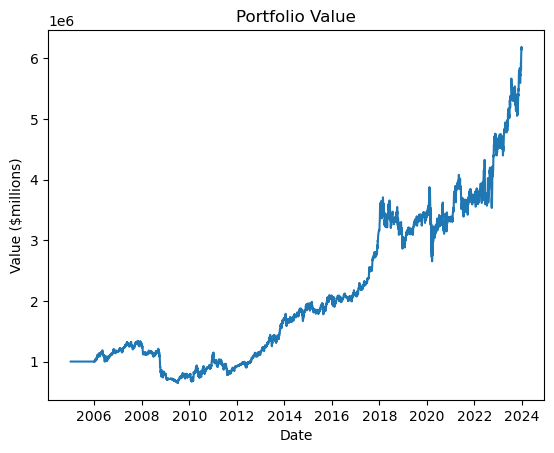

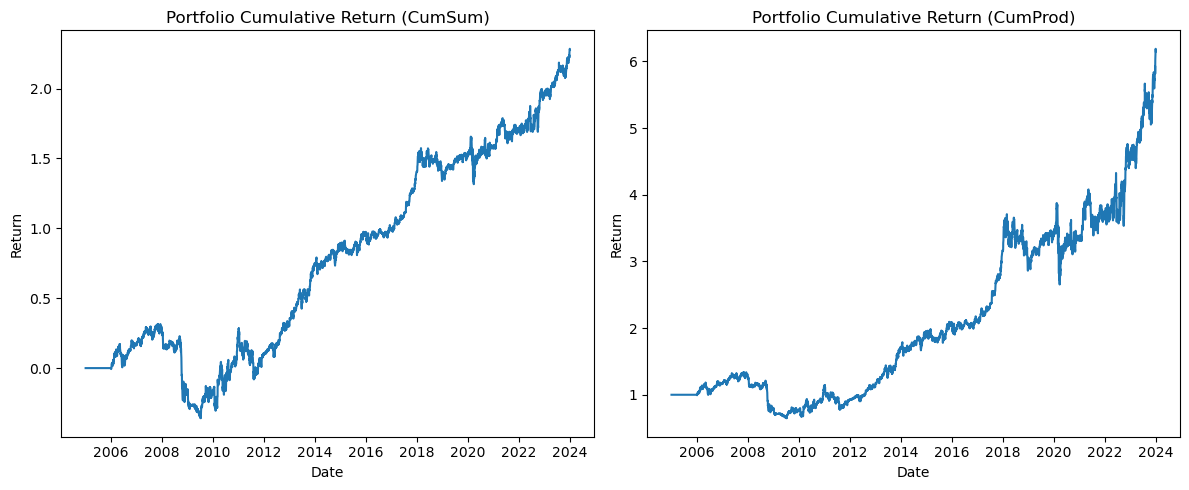

In [34]:
plot_performance(trade_1)

## Forecasted Daily Rolling Kelly

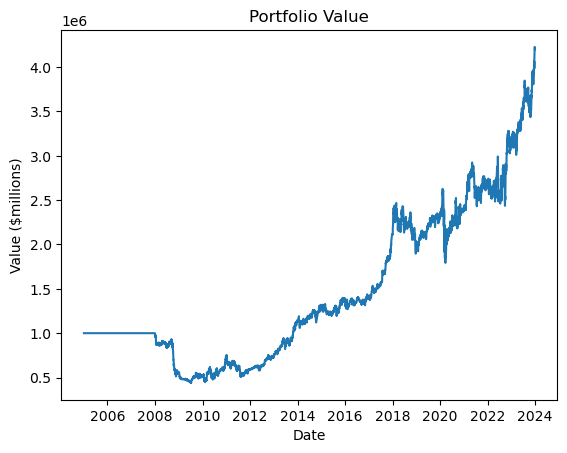

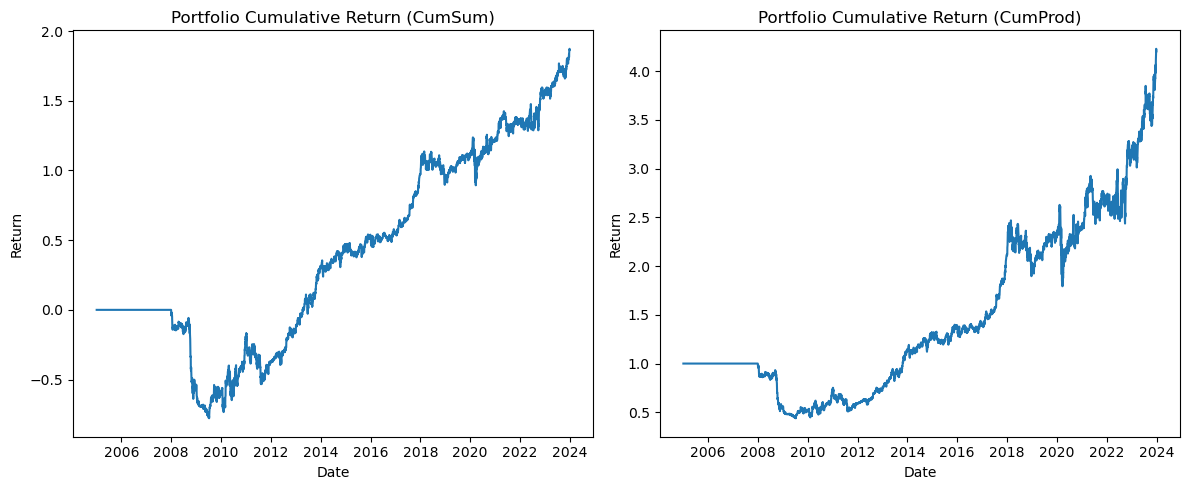

In [27]:
plot_performance(trade_2)

### Plot of Covariance Matrix Prediction Errors

In [29]:
sse_cholesky=pd.read_csv("sse_cholesky.csv")
sse_cholesky.rename(columns={"Unnamed: 0":"date"},inplace=True)
sse_cholesky["date"] = pd.to_datetime(sse_cholesky["date"])
sse_cholesky.set_index("date",inplace=True)

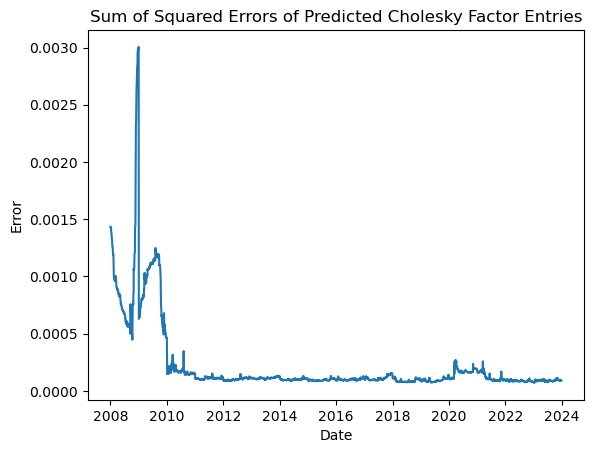

In [31]:
plt.plot(sse_cholesky.index, sse_cholesky['sse_cholesky'])
plt.title('Sum of Squared Errors of Predicted Cholesky Factor Entries')
plt.xlabel('Date')
plt.ylabel('Error')
plt.show()

## Monthly Rolling Kelly

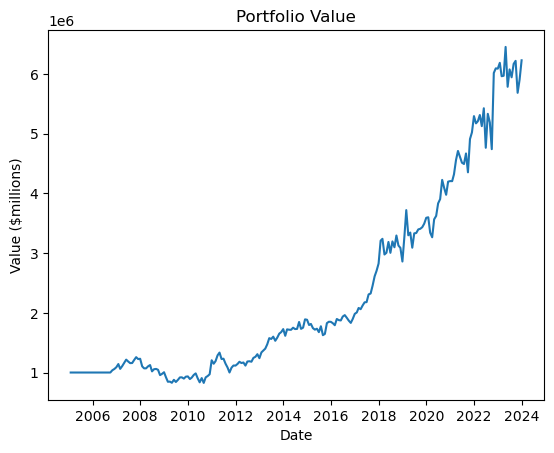

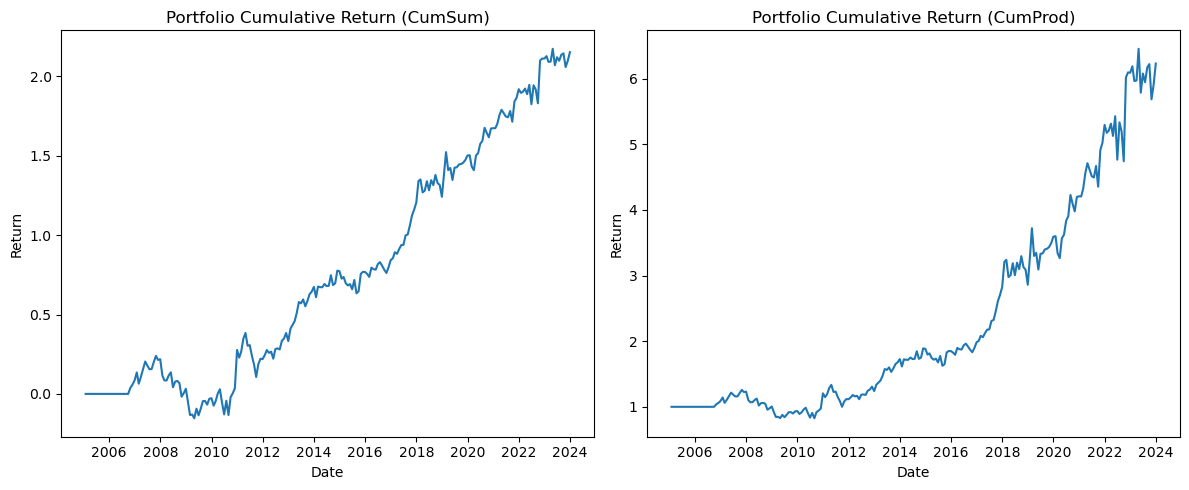

In [28]:
plot_performance(trade_3)